In [1]:
import pandas as pd
import numpy as np
import time
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import DistanceMetric
from sklearn_extra.cluster import KMedoids
import matplotlib.pyplot as plt
import statistics
import pyclustering
from pyclustering.cluster.kmedoids import kmedoids
import gower
import seaborn as sns
import pyclustering
from sklearn.metrics.pairwise import pairwise_distances
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster.kmedoids import kmedoids

# Read dataset

In [2]:
df = pd.read_excel("german_credit_data.xlsx")
df['label'] = (df.Risk == 'good').astype(int)
df.drop(['Unnamed: 0','Risk'],axis=1,inplace=True)
df = df.replace(np.nan, 'unknown', regex=True)
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,label
0,67,male,2,own,unknown,little,1169,6,radio/TV,1
1,22,female,2,own,little,moderate,5951,48,radio/TV,0
2,49,male,1,own,little,unknown,2096,12,education,1
3,45,male,2,free,little,little,7882,42,furniture/equipment,1
4,53,male,2,free,little,little,4870,24,car,0


Below we define which features are categorical and which are numerical. 

In [3]:
#Create lists of categorical and numerical features
num_features = ['Age','Credit amount','Duration']
cat_features = ['Sex','Job','Housing','Saving accounts','Checking account','Purpose']
all_features = ['Age','Credit amount','Duration','Sex','Job','Housing','Saving accounts','Checking account','Purpose']

# k-medoids clustering

### Defining functions

In [4]:
#This function compute the Gower distance matrix
# input: NxM feature matrix
# output: NxN distance matrix 

def gower_distance(matrix):
    output = gower.gower_matrix(matrix)
    return output

In [5]:
#This function computes the standard deviation of numerical features

def numerical_std(numerical_variable):
    name = numerical_variable.name
    Vmin = numerical_variable.min()
    Vmax = numerical_variable.max()
    Vnorm = (numerical_variable-Vmin)/(Vmax-Vmin)
    norm_std = statistics.stdev(Vnorm.tolist())
    return norm_std

In [6]:
#This function computes the variation of categorical features 

def categorical_variation(categorical_variable):
    name = categorical_variable.name
    q = categorical_variable.nunique()
    n = categorical_variable.count() 
    values_list = categorical_variable.drop_duplicates().to_list()
    if (q==1):
        return 0 
    else:
        frequencies = []
        for val in values_list:
            f = categorical_variable.value_counts()[val] / n
            frequencies.append(f)
        f2 = 0
        for i in np.arange(q):
            f2 += (frequencies[i]**2)
        v = 1 - np.sqrt(f2)
        v_s = v / (1-1/(np.sqrt(q)))
        return v_s

In [7]:
#This function computes the variability of a cluster

def variability(matrix,clusters,cluster_number):
    c_indices = clusters[cluster_number]
    matrix_subset = matrix.loc[c_indices,:]
    dict_var = {}
    for column in matrix.columns:
        if (column in cat_features):
            dict_var[column] = categorical_variation(matrix_subset[column])
            #print(column , '\t', "%.2f" % categorical_variation(matrix_subset[column]))
        elif (column in num_features):
            #print(column , '\t', "%.2f" % min(numerical_std(matrix_subset[column])/np.sqrt(1/12),1) )
            dict_var[column] = min(numerical_std(matrix_subset[column])/np.sqrt(1/12),1)
    return dict_var

### Clustering algorithm

In [8]:
# -------------------------------------------------------------------------------------
# Define the cluster target (X), the number of clusters (k), max number of layers (l>>) 
# and thershold size for cluster cardinality (n)
# -------------------------------------------------------------------------------------

X = df.loc[: , df.columns != 'label']
y = df.loc[: , df.columns == 'label']
k = 2 #number of clusters each clustering step
l = 50 #max number of layers
n = len(X) #size of dataset


# -------------------------------------------------------------------------------------
# Semi-hierarchical clustering algorithm 
# -------------------------------------------------------------------------------------

t0 = time.time() # report running time 

dict_layers = {0:[X.index.tolist()]}
dict_medoids = {0:[]}
for i in np.arange(1,l):
    dict_layers[i] = []
    dict_medoids[i] = []

for layer in np.arange(l-1): #iterate over layers
    final_layer = True
    
    for i in np.arange(k**layer): #iterate over clusters in layer 
        subset_index = dict_layers[layer][i]
        if (subset_index == [None]):
            for j in np.arange(k):
                dict_layers[layer+1].append([None])
                dict_medoids[layer+1].append([None])
        
        elif (len(subset_index) < 0.05*n): #clusters should be > 5 percent of whole dataset
            dict_layers[layer+1].append(dict_layers[layer][i])
            dict_medoids[layer+1].append(dict_medoids[layer][i])
            dict_layers[layer+1].append([None])
            dict_medoids[layer+1].append([None])
        
        else:
            X_subset = X.loc[subset_index,:]
            var_subset = variability(X,dict_layers[layer],i)#check the variability of cluster 
            test_variability = False 
            for feature in all_features:
                if((var_subset[feature]>0.2) and (var_subset[feature]<0.8) ):#c_u and c_l 
                    test_variability = True
            
            if (test_variability == False):
                dict_layers[layer+1].append(dict_layers[layer][i])
                dict_medoids[layer+1].append(dict_medoids[layer][i])
                dict_layers[layer+1].append([None])
                dict_medoids[layer+1].append([None])
                
            else:
                index_book = {} #keep track of indices of cluster i
                teller = 0 
                for index in X_subset.index:
                    index_book[teller] = index
                    teller += 1
        
                X_subset = X_subset.reset_index(drop=True) #reset index of cluster i before cluster analysis
        
                initial_medoids = np.sort(random.sample(list(X_subset.index),k))
                kmedoids_instance = kmedoids(gower_distance(X_subset),initial_medoids,data_type='distance_matrix',iter_max=1000)
                kmedoids_instance.process()
                clusters = kmedoids_instance.get_clusters()
                centers = kmedoids_instance.get_medoids()
                final_layer = False
    
                for j in np.arange(k): #translate cluster index back to original
                    translated_cluster = []
                    for item in clusters[j]:
                        translated_cluster.append(index_book[item])
                    dict_medoids[layer+1].append(index_book[centers[j]])
                    dict_layers[layer+1].append(translated_cluster)

    if (final_layer == True):
        end_layer = layer
        break
        
final_clusters_full = dict_layers[end_layer]
final_medoids_full = dict_medoids[end_layer]

final_clusters = []
final_medoids = []
for cluster in final_clusters_full:
    if (cluster != [None]):
        final_clusters.append(cluster)
for medoid in final_medoids_full:
    if (medoid != [None]):
        final_medoids.append(medoid)    
    
#sort the clusters, in this way we always obtain the same cluster numbers 
sort_clusters = final_clusters.copy()
sort_clusters.sort(key=len)
sort_centers = []
for i in np.arange(len(final_clusters)):
    for j in np.arange(len(final_clusters)):
        if (sort_clusters[i] == final_clusters[j]):
            sort_centers.append(final_medoids[j])

            
print("training time:", round(time.time()-t0, 3), "s")
print("Final number of clusters:", len(sort_clusters))

training time: 3.833 s
Final number of clusters: 35


### Info about clustering outcome 

In [9]:
# Print the clusters and 

for i in np.arange(len(final_clusters)):
    print('-----------')
    print('cluster ', i, '\t', sort_clusters[i] , '\t', 'medoid ', sort_centers[i])

-----------
cluster  0 	 [100, 104, 231, 247, 280, 413, 488, 695, 859] 	 medoid  488
-----------
cluster  1 	 [53, 55, 270, 314, 476, 505, 748, 764, 860, 916, 962] 	 medoid  270
-----------
cluster  2 	 [37, 38, 123, 213, 344, 506, 626, 648, 699, 756, 774, 793, 871] 	 medoid  871
-----------
cluster  3 	 [6, 183, 190, 200, 237, 283, 354, 449, 628, 674, 754, 816, 830, 870] 	 medoid  6
-----------
cluster  4 	 [19, 40, 160, 191, 232, 253, 279, 408, 567, 666, 688, 949, 963, 991] 	 medoid  949
-----------
cluster  5 	 [63, 142, 145, 152, 217, 230, 235, 477, 561, 639, 731, 789, 887, 907, 951, 998] 	 medoid  639
-----------
cluster  6 	 [27, 69, 80, 92, 135, 211, 259, 399, 448, 550, 702, 723, 836, 856, 873, 975, 987] 	 medoid  135
-----------
cluster  7 	 [83, 108, 118, 166, 312, 319, 396, 429, 441, 471, 573, 610, 640, 711, 722, 750, 751, 771, 802] 	 medoid  166
-----------
cluster  8 	 [29, 74, 76, 84, 114, 131, 212, 239, 274, 289, 321, 438, 552, 594, 644, 718, 813, 818, 890] 	 medoid  239


# Train ML algorithm 

In [10]:
import xgboost as xgb
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error

In [11]:
data = df.loc[: , df.columns != 'label']
label = df.loc[: , df.columns == 'label']

le = preprocessing.LabelEncoder()
for column in cat_features:
    le.fit(data[column])
    data[column] = le.fit_transform(data[column])

X_train, X_test, y_train, y_test = train_test_split(data, np.ravel(label), test_size=0.30, random_state=78) # 70% training and 30% test

<ipython-input-11-e9bf63b1c235>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column] = le.fit_transform(data[column])


### 1. Logistic Regression 

In [12]:
#train logistic regression model and check performance
clf = LogisticRegression(random_state=100,max_iter=500).fit(X_train, y_train)
clf_predictions_train = clf.predict(X_train)
clf_predictions_test = clf.predict(X_test)
clf_predictions_total = clf.predict(data)

p_correct_train = 1 - (abs(clf_predictions_train-y_train).sum() / len(y_train))
p_correct_test = 1 - (abs(clf_predictions_test-y_test).sum() / len(y_test))
p_correct_total = 1 - (abs(clf_predictions_total-np.ravel(label)).sum() / len(np.ravel(label)))

print('correct predictions train set' ,'\t', p_correct_train*100)
print('correct predictions test set' , '\t',  p_correct_test*100)
print('correct predictions total set' , '\t', p_correct_total*100)

correct predictions train set 	 74.28571428571429
correct predictions test set 	 73.66666666666667
correct predictions total set 	 74.1


### 2. XGboost classifier

In [13]:
#train XGboost
xg_clf = xgb.XGBClassifier(max_depth=5, gamma=1, use_label_encoder=False,eval_metric='error')
xg_clf.fit(X_train, y_train)

xg_predictions_train = xg_clf.predict(X_train)
xg_predictions_test = xg_clf.predict(X_test)
xg_predictions_total = xg_clf.predict(data)

p_correct_train = 1 - (abs(xg_predictions_train-y_train).sum() / len(y_train))
p_correct_test = 1 - (abs(xg_predictions_test-y_test).sum() / len(y_test))
p_correct_total = 1 - (abs(xg_predictions_total-np.ravel(label)).sum() / len(np.ravel(label)))

print('correct predictions train set' ,'\t', p_correct_train*100)
print('correct predictions test set' , '\t',  p_correct_test*100)
print('correct predictions total set' , '\t', p_correct_total*100)

correct predictions train set 	 91.0
correct predictions test set 	 74.0
correct predictions total set 	 85.9


### 3. Support Vector Machine classifier 

In [14]:
from sklearn import svm

svm_clf = svm.SVC()
svm_clf.fit(X_train,y_train)

svm_predictions_train = svm_clf.predict(X_train)
svm_predictions_test = svm_clf.predict(X_test)
svm_predictions_total = svm_clf.predict(data)

p_correct_train = 1 - (abs(svm_predictions_train-y_train).sum() / len(y_train))
p_correct_test = 1 - (abs(svm_predictions_test-y_test).sum() / len(y_test))
p_correct_total = 1 - (abs(svm_predictions_total-np.ravel(label)).sum() / len(np.ravel(label)))

print('correct predictions train set' ,'\t', p_correct_train*100)
print('correct predictions test set' , '\t',  p_correct_test*100)
print('correct predictions total set' , '\t', p_correct_total*100)

correct predictions train set 	 71.28571428571429
correct predictions test set 	 69.66666666666667
correct predictions total set 	 70.8


# 3.a Evaluation of Clustering method 

## Stability towards initialization 

We test the stability of the clustering method towards the initialization of the clusters by running the algorithm multiple times for different (random) initializations and compare the final clusters. 

In [15]:
test_stability = [] #list with unique cluster-combinations
all_clusters = [] #list with all clusters
test_medoids = [] #list with medoids of the unique cluster-combinations
t_s = 100 #number of runs
list_time = []

for test in np.arange(t_s):
    t0=time.time()

    dict_layers = {0:[X.index.tolist()]}
    dict_medoids = {0:[]}
    for i in np.arange(1,l):
        dict_layers[i] = []
        dict_medoids[i] = []


    for layer in np.arange(l-1): #iterate over layers
        final_layer = True
    
        for i in np.arange(k**layer): #iterate over clusters in layer 
            subset_index = dict_layers[layer][i]
            if (subset_index == [None]):
                for j in np.arange(k):
                    dict_layers[layer+1].append([None])
                    dict_medoids[layer+1].append([None])
        
            elif (len(subset_index) < 0.05*n):
                dict_layers[layer+1].append(dict_layers[layer][i])
                dict_medoids[layer+1].append(dict_medoids[layer][i])
                dict_layers[layer+1].append([None])
                dict_medoids[layer+1].append([None])
        
            else:
                X_subset = X.loc[subset_index,:]
                var_subset = variability(X,dict_layers[layer],i)#check the variability of cluster 
                test_variability = False 
                for feature in all_features:
                    if((var_subset[feature]>0.2) and (var_subset[feature]<0.8) ):
                        test_variability = True
            
                if (test_variability == False):
                    dict_layers[layer+1].append(dict_layers[layer][i])
                    dict_medoids[layer+1].append(dict_medoids[layer][i])
                    dict_layers[layer+1].append([None])
                    dict_medoids[layer+1].append([None])
                
                else:
                    index_book = {} #keep track of indices of cluster i
                    teller = 0 
                    for index in X_subset.index:
                        index_book[teller] = index
                        teller += 1
        
                    X_subset = X_subset.reset_index(drop=True) #reset index of cluster i before cluster analysis
        
                    initial_medoids = np.sort(random.sample(list(X_subset.index),k))
                    kmedoids_instance = kmedoids(gower_distance(X_subset),initial_medoids,data_type='distance_matrix',iter_max=1000)
                    kmedoids_instance.process()
                    clusters = kmedoids_instance.get_clusters()
                    centers = kmedoids_instance.get_medoids()
                    final_layer = False
    
                    for j in np.arange(k): #translate cluster index back to original
                        translated_cluster = []
                        for item in clusters[j]:
                            translated_cluster.append(index_book[item])
                        dict_medoids[layer+1].append(index_book[centers[j]])
                        dict_layers[layer+1].append(translated_cluster)

        if (final_layer == True):
            end_layer = layer
            break
        
    final_clusters_full = dict_layers[end_layer]
    final_medoids_full = dict_medoids[end_layer]

    ts_final_clusters = []
    ts_final_medoids = []
    for cluster in final_clusters_full:
        if (cluster != [None]):
            ts_final_clusters.append(cluster)
    for medoid in final_medoids_full:
        if (medoid != [None]):
            ts_final_medoids.append(medoid)    
    
    #sort the clusters, in this way we always obtain the same cluster numbers 
    ts_clusters = ts_final_clusters.copy()
    ts_centers = ts_final_medoids.copy()
    
    #check if the cluster already occured in previous run
    if (sorted(ts_clusters) not in test_stability):
        test_stability.append(sorted(ts_clusters)) #if not append cluster to list
        sort_centers = []
        for p in np.arange(len(ts_clusters)):
            for q in np.arange(len(ts_clusters)):
                if (sorted(ts_clusters)[p] == ts_clusters[q]):
                    sort_centers.append(ts_centers[q])
        test_medoids.append(sort_centers)
    all_clusters.append(sorted(ts_clusters))
    
    list_time.append(round(time.time()-t0, 3))

print('We found ' , len(test_stability) ,' different cluster-combination(s) when running the clustering algorithm ', t_s , 'times')
print('mean running time : ', statistics.mean(list_time), '\t', 'std dev : ' , statistics.stdev(list_time))

We found  46  different cluster-combination(s) when running the clustering algorithm  100 times
mean running time :  3.54388 	 std dev :  1.3293218843919001


In [126]:
count_combo = 0
list_long = []
dict_count = {}

for combo in test_stability: 
    count = 0
    for item in all_clusters:
        if (item == combo):
            count += 1 
    print('cluster-combination ', count_combo , ' occurs ', count, ' times, and has ', len(combo), ' clusters')
    dict_count[count_combo] = count
    if (count>1):
        list_long.append(count_combo)
    count_combo += 1

cluster-combination  0  occurs  28  times, and has  34  clusters
cluster-combination  1  occurs  1  times, and has  39  clusters
cluster-combination  2  occurs  4  times, and has  35  clusters
cluster-combination  3  occurs  2  times, and has  34  clusters
cluster-combination  4  occurs  7  times, and has  38  clusters
cluster-combination  5  occurs  1  times, and has  35  clusters
cluster-combination  6  occurs  1  times, and has  37  clusters
cluster-combination  7  occurs  1  times, and has  40  clusters
cluster-combination  8  occurs  1  times, and has  39  clusters
cluster-combination  9  occurs  1  times, and has  41  clusters
cluster-combination  10  occurs  1  times, and has  40  clusters
cluster-combination  11  occurs  4  times, and has  33  clusters
cluster-combination  12  occurs  1  times, and has  40  clusters
cluster-combination  13  occurs  2  times, and has  35  clusters
cluster-combination  14  occurs  1  times, and has  39  clusters
cluster-combination  15  occurs  2

In [132]:
def compare_cluster_combo(i,j,test_stability):
    comb1 = i
    comb2 = j
    list_same_max = []

    for cluster1 in test_stability[comb1]:
        list_same_elements = []
        for cluster2 in test_stability[comb2]:
            count = 0
            for element in cluster1:
                if (element in cluster2):
                    count += 1
            list_same_elements.append(count / len(cluster1))
        list_same_max.append(max(list_same_elements))
    return sum(list_same_max) / len(list_same_max)

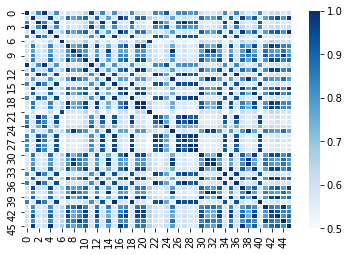

In [133]:
dict_compare_combo = {}

for i in np.arange(len(test_stability)):
    dict_compare_combo[i] = []
    for j in np.arange(len(test_stability)):
        if (i == j):
            dict_compare_combo[i].append(1)
        else:
            dict_compare_combo[i].append(compare_cluster_combo(i,j,test_stability))
            
df_sim = pd.DataFrame.from_dict(dict_compare_combo)
ax = sns.heatmap(df_sim, vmin=0.5, vmax=1 , linewidths=0.1 , cmap='Blues'  )

We can also make a stability plot of the cluster-combinations that occur more than once (see list above). 

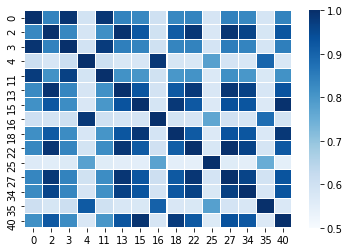

In [121]:
list_long
dict_compare_long = {}

for i in list_long:
    dict_compare_long[i] = []
    for j in list_long:
        if (i == j):
            dict_compare_long[i].append(1)
        else:
            dict_compare_long[i].append(compare_cluster_combo(i,j,test_stability))
             
df_sim_long = pd.DataFrame.from_dict(dict_compare_long, orient='index', columns=list_long)
ax = sns.heatmap(df_sim_long, vmin=0.5, vmax=1 , linewidths=0.1 , cmap='Blues'  )

In [20]:
#If there occurs more than one cluster-combination, set the clusters used for further analysis to the most common cluster
perturbation = 0 #the most occuring cluster-combination

#sort the clusters, in this way we always obtain the same cluster numbers 
sort_clusters = test_stability[perturbation].copy()
sort_clusters.sort(key=len)
sort_centers = []
for i in np.arange(len(sort_clusters)):
    for j in np.arange(len(sort_clusters)):
        if (sort_clusters[i] == test_stability[perturbation][j]):
            sort_centers.append(test_medoids[perturbation][j])

In [21]:
for i in np.arange(len(sort_clusters)):
    print('-----------')
    print('cluster ', i, '\t', sort_clusters[i] , '\t', 'medoid ', sort_centers[i])

-----------
cluster  0 	 [247, 280, 488, 489, 859, 916] 	 medoid  859
-----------
cluster  1 	 [5, 65, 266, 294, 622, 657, 868, 886, 977] 	 medoid  868
-----------
cluster  2 	 [48, 106, 213, 390, 411, 440, 511, 606, 672, 738, 772, 778, 880, 888] 	 medoid  106
-----------
cluster  3 	 [63, 142, 145, 152, 217, 230, 235, 477, 561, 639, 731, 789, 887, 907, 951, 998] 	 medoid  639
-----------
cluster  4 	 [19, 40, 46, 109, 160, 162, 244, 279, 408, 533, 567, 710, 773, 786, 921, 949, 963] 	 medoid  19
-----------
cluster  5 	 [27, 69, 80, 92, 135, 211, 259, 399, 448, 550, 702, 723, 836, 856, 873, 975, 987] 	 medoid  135
-----------
cluster  6 	 [13, 157, 182, 201, 285, 325, 416, 472, 516, 529, 588, 693, 737, 823, 892, 906, 929, 958, 969] 	 medoid  929
-----------
cluster  7 	 [21, 22, 170, 456, 494, 528, 586, 596, 613, 617, 649, 668, 755, 770, 826, 850, 900, 914, 972] 	 medoid  586
-----------
cluster  8 	 [29, 74, 76, 84, 114, 131, 212, 239, 274, 289, 321, 438, 552, 594, 644, 718, 813, 818,

In [22]:
#summary of the meadoids of the cluster combination that occurred most times
df_medoids = X.loc[sort_centers,:]
indices_list = np.arange(34)
df_medoids['Cluster'] = indices_list
df_medoids

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Cluster
859,26,male,2,rent,moderate,unknown,3577,9,car,0
868,37,male,2,own,unknown,unknown,7409,36,business,1
106,39,male,3,own,little,unknown,6458,18,car,2
639,26,male,2,own,little,little,4370,42,radio/TV,3
19,31,male,2,own,quite rich,unknown,3430,24,radio/TV,4
135,38,female,2,own,unknown,unknown,1240,12,radio/TV,5
929,43,male,1,own,little,little,1344,12,car,6
586,36,male,2,rent,little,little,2799,9,car,7
239,39,male,2,own,little,little,2522,30,radio/TV,8
169,31,male,2,own,little,moderate,1935,24,business,9


In [114]:
df_medoids.to_csv('medoids.csv')

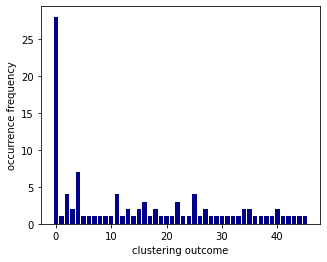

In [131]:
#histogram that shows how often each cluster-combination occurs when running the algorithm 100 times

plt.figure(figsize=(5,4))
plt.bar(dict_count.keys(), dict_count.values(),  color='darkblue')
plt.xlabel('clustering outcome')
plt.ylabel('occurrence frequency')

plt.show()

## Variability

In [30]:
def print_variability(matrix,clusters,cluster_number):
    c_indices = clusters[cluster_number]
    matrix_subset = matrix.loc[c_indices,:]
    for column in matrix.columns:
        if (column in cat_features):
            print(column , '\t', "%.2f" % categorical_variation(matrix_subset[column]))
        elif (column in num_features):
            print(column , '\t', "%.2f" % min(numerical_std(matrix_subset[column])/np.sqrt(1/12),1) )

In [31]:
def variability2(matrix,clusters,cluster_number):
    c_indices = clusters[cluster_number]
    matrix_subset = matrix.loc[c_indices,:]
    list_var = []
    for column in matrix.columns:
        if (column in cat_features):
            list_var.append(categorical_variation(matrix_subset[column]))
        elif (column in num_features):
            list_var.append(min(numerical_std(matrix_subset[column])/np.sqrt(1/12),1))
    return list_var

Variability plot shows for each cluster the feature-wise variability, where 0 indicates a low variability and 1 a high variability. 

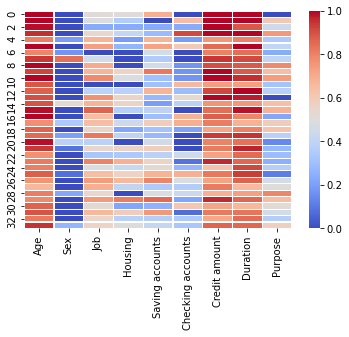

In [113]:
dict_var = {}
for i in np.arange(len(sort_clusters)):
    dict_var[i] = variability2(X,sort_clusters,i)

df_var = pd.DataFrame.from_dict(dict_var, orient='index', columns=['Age','Sex','Job','Housing','Saving accounts','Checking accounts','Credit amount','Duration','Purpose'])
ax = sns.heatmap(df_var, vmin=0, vmax=1 , linewidths=0.1 , cmap='coolwarm'  )


In [33]:
for i in np.arange(len(sort_clusters)):
    print('---Variability of cluster ',i,'---')
    print_variability(X,sort_clusters,i)

---Variability of cluster  0 ---
Age 	 1.00
Sex 	 0.00
Job 	 0.51
Housing 	 0.51
Saving accounts 	 0.69
Checking account 	 0.00
Credit amount 	 1.00
Duration 	 1.00
Purpose 	 0.00
---Variability of cluster  1 ---
Age 	 1.00
Sex 	 0.00
Job 	 0.49
Housing 	 0.36
Saving accounts 	 0.00
Checking account 	 0.65
Credit amount 	 1.00
Duration 	 1.00
Purpose 	 0.61
---Variability of cluster  2 ---
Age 	 0.99
Sex 	 0.00
Job 	 0.23
Housing 	 0.23
Saving accounts 	 0.23
Checking account 	 0.23
Credit amount 	 1.00
Duration 	 0.89
Purpose 	 0.45
---Variability of cluster  3 ---
Age 	 0.96
Sex 	 0.00
Job 	 0.54
Housing 	 0.42
Saving accounts 	 0.29
Checking account 	 0.92
Credit amount 	 1.00
Duration 	 1.00
Purpose 	 0.75
---Variability of cluster  4 ---
Age 	 0.81
Sex 	 0.19
Job 	 0.68
Housing 	 0.19
Saving accounts 	 0.68
Checking account 	 0.19
Credit amount 	 0.76
Duration 	 0.81
Purpose 	 0.34
---Variability of cluster  5 ---
Age 	 1.00
Sex 	 0.00
Job 	 0.74
Housing 	 0.27
Saving accounts 	 0

# 3.b Evaluation of ML models

We evaluate the dataset and the three selected ADM models for different types of bias, using the most ocurring clustering-combination as profiles. 

## Historical Bias 

We first evaluate the whole dataset for historical bias by looking for demographic disparity. The protected class in this case are female, the disadvantaged group has credit-label 'bad' and the advantaged group has credit-label 'good'. 

In [34]:
D_f = len(df.loc[(df.label==0) & (df.Sex=='female')])
D_fm = len(df.loc[df.label==0])
D= D_f/D_fm

A_f = len(df.loc[(df.label==1) & (df.Sex=='female')])
A_fm = len(df.loc[df.label==1])
A= A_f/A_fm
print('D: ', "%.2f" % D)
print('A: ', "%.2f" % A)

D:  0.36
A:  0.29


We do the same computations, only now for the different profiles (clusters) instead of the whole dataset. 

In [35]:
for i in np.arange(len(sort_clusters)):
    df_c = df.loc[sort_clusters[i]]
    D_fc = len(df_c.loc[(df_c.label==0) & (df_c.Sex=='female')])
    D_fmc = len(df_c.loc[df_c.label==0])
    A_fc = len(df_c.loc[(df_c.label==1) & (df_c.Sex=='female')])
    A_fmc = len(df_c.loc[df_c.label==1])
    if (D_fmc == 0):
        D_c = 0
    else:
        D_c = D_fc/D_fmc
    if (A_fmc == 0):
        A_c = 0
    else:
        A_c = A_fc/A_fmc
    print('Cluster ',i,': ' , '\t' , 'D:' , "%.2f" % D_c , '\t' , 'A:' , "%.2f" % A_c )

Cluster  0 :  	 D: 0.00 	 A: 0.00
Cluster  1 :  	 D: 0.00 	 A: 0.00
Cluster  2 :  	 D: 0.00 	 A: 0.00
Cluster  3 :  	 D: 0.00 	 A: 0.00
Cluster  4 :  	 D: 0.00 	 A: 0.07
Cluster  5 :  	 D: 1.00 	 A: 1.00
Cluster  6 :  	 D: 0.00 	 A: 0.08
Cluster  7 :  	 D: 0.36 	 A: 0.25
Cluster  8 :  	 D: 0.00 	 A: 0.00
Cluster  9 :  	 D: 0.00 	 A: 0.00
Cluster  10 :  	 D: 1.00 	 A: 1.00
Cluster  11 :  	 D: 0.00 	 A: 0.00
Cluster  12 :  	 D: 0.00 	 A: 0.00
Cluster  13 :  	 D: 0.00 	 A: 0.00
Cluster  14 :  	 D: 0.00 	 A: 0.19
Cluster  15 :  	 D: 1.00 	 A: 1.00
Cluster  16 :  	 D: 1.00 	 A: 1.00
Cluster  17 :  	 D: 1.00 	 A: 0.86
Cluster  18 :  	 D: 0.00 	 A: 0.00
Cluster  19 :  	 D: 0.06 	 A: 0.06
Cluster  20 :  	 D: 0.24 	 A: 0.00
Cluster  21 :  	 D: 0.00 	 A: 0.03
Cluster  22 :  	 D: 0.00 	 A: 0.00
Cluster  23 :  	 D: 0.00 	 A: 0.00
Cluster  24 :  	 D: 0.00 	 A: 0.00
Cluster  25 :  	 D: 0.00 	 A: 0.03
Cluster  26 :  	 D: 1.00 	 A: 1.00
Cluster  27 :  	 D: 0.00 	 A: 0.00
Cluster  28 :  	 D: 0.96 	 A: 

We now compute for each profile the fraction of the profile that has label 'bad' (D) and 'good' (A), not taking the sex of individuals into account. 

In [37]:
for i in np.arange(len(sort_clusters)):
    frac_good = (sum(df.loc[sort_clusters[i]].label) / len(sort_clusters[i])) 
    print('Cluster ' , i, '\t', 'D' ,"%.2f" % (1-frac_good), '\t' , 'A', "%.2f" % frac_good)
    #print("%.2f" % frac_good , ' percent of Cluster ', i , ' has label good')

Cluster  0 	 D 0.00 	 A 1.00
Cluster  1 	 D 0.11 	 A 0.89
Cluster  2 	 D 0.14 	 A 0.86
Cluster  3 	 D 0.62 	 A 0.38
Cluster  4 	 D 0.12 	 A 0.88
Cluster  5 	 D 0.12 	 A 0.88
Cluster  6 	 D 0.32 	 A 0.68
Cluster  7 	 D 0.58 	 A 0.42
Cluster  8 	 D 0.58 	 A 0.42
Cluster  9 	 D 0.47 	 A 0.53
Cluster  10 	 D 0.53 	 A 0.47
Cluster  11 	 D 0.18 	 A 0.82
Cluster  12 	 D 0.35 	 A 0.65
Cluster  13 	 D 0.52 	 A 0.48
Cluster  14 	 D 0.09 	 A 0.91
Cluster  15 	 D 0.62 	 A 0.38
Cluster  16 	 D 0.38 	 A 0.62
Cluster  17 	 D 0.25 	 A 0.75
Cluster  18 	 D 0.19 	 A 0.81
Cluster  19 	 D 0.50 	 A 0.50
Cluster  20 	 D 0.52 	 A 0.48
Cluster  21 	 D 0.05 	 A 0.95
Cluster  22 	 D 0.36 	 A 0.64
Cluster  23 	 D 0.15 	 A 0.85
Cluster  24 	 D 0.37 	 A 0.63
Cluster  25 	 D 0.29 	 A 0.71
Cluster  26 	 D 0.45 	 A 0.55
Cluster  27 	 D 0.14 	 A 0.86
Cluster  28 	 D 0.52 	 A 0.48
Cluster  29 	 D 0.40 	 A 0.60
Cluster  30 	 D 0.09 	 A 0.91
Cluster  31 	 D 0.22 	 A 0.78
Cluster  32 	 D 0.13 	 A 0.87
Cluster  33 	 D 0.06

## Representational Bias 

For representational bias we create a tabel that shows how often each profile occurs.

In [38]:
list_cluster = []
abs_freq = []
rel_freq = []

for i in np.arange(len(sort_clusters)):
    list_cluster.append(i)
    abs_freq.append(len(sort_clusters[i]))
    rel_freq.append(len(sort_clusters[i])/n)

pd.DataFrame(list(zip(list_cluster, abs_freq, rel_freq)),columns =['Cluster', 'Abs. frequency', 'Rel. frequency'])

,Cluster,Abs. frequency,Rel. frequency
0,0,6,0.006
1,1,9,0.009
2,2,14,0.014
3,3,16,0.016
4,4,17,0.017
5,5,17,0.017
6,6,19,0.019
7,7,19,0.019
8,8,19,0.019
9,9,19,0.019


## Aggregation Bias 

For each cluster we will compute the probability of getting the wrong label. 

In [39]:
#input: array with predicted labels, array with true labels
#output: percentage correct predicted labels 

def correct_predicted(predicted_labels,true_labels):
    output = (1 - (abs(predicted_labels-true_labels).sum() / len(true_labels))) 
    return output


We will also compute the probability of getting an unjustified disadvantage ('bad') label. 

In [40]:
def wrong_disadvantage(predicted_labels,true_labels):
    count = 0 
    size = len(true_labels)
    for i in np.arange(size):
        if ((predicted_labels[i]==0) & (true_labels[i]==1)):
            count += 1
    output = count / size
    return output    

### 1. Logistic Regression 

In [41]:
for i in np.arange(len(sort_clusters)):
    indices = sort_clusters[i]
    subset_X = data.loc[indices,:]
    subset_y = label.loc[indices,:]
    clf_predictions_cluster = clf.predict(subset_X)
    print('Cluster ', i , '\t', correct_predicted(clf_predictions_cluster,np.ravel(subset_y)))

Cluster  0 	 1.0
Cluster  1 	 0.8888888888888888
Cluster  2 	 0.7857142857142857
Cluster  3 	 0.75
Cluster  4 	 0.8823529411764706
Cluster  5 	 0.8823529411764706
Cluster  6 	 0.631578947368421
Cluster  7 	 0.6842105263157895
Cluster  8 	 0.631578947368421
Cluster  9 	 0.5789473684210527
Cluster  10 	 0.5789473684210527
Cluster  11 	 0.8636363636363636
Cluster  12 	 0.7391304347826086
Cluster  13 	 0.6086956521739131
Cluster  14 	 0.9130434782608696
Cluster  15 	 0.5833333333333333
Cluster  16 	 0.6923076923076923
Cluster  17 	 0.75
Cluster  18 	 0.7741935483870968
Cluster  19 	 0.53125
Cluster  20 	 0.6363636363636364
Cluster  21 	 0.9473684210526316
Cluster  22 	 0.6923076923076923
Cluster  23 	 0.8461538461538461
Cluster  24 	 0.5121951219512195
Cluster  25 	 0.7380952380952381
Cluster  26 	 0.6136363636363636
Cluster  27 	 0.8636363636363636
Cluster  28 	 0.6590909090909092
Cluster  29 	 0.5555555555555556
Cluster  30 	 0.8888888888888888
Cluster  31 	 0.8
Cluster  32 	 0.872340425

### 2. XGboost classifier 

In [42]:
for i in np.arange(len(sort_clusters)):
    indices = sort_clusters[i]
    subset_X = data.loc[indices,:]
    subset_y = label.loc[indices,:]
    xg_predictions_cluster = xg_clf.predict(subset_X)
    print('Cluster ', i , '\t', correct_predicted(xg_predictions_cluster,np.ravel(subset_y)))

Cluster  0 	 1.0
Cluster  1 	 0.8888888888888888
Cluster  2 	 0.9285714285714286
Cluster  3 	 0.9375
Cluster  4 	 0.8823529411764706
Cluster  5 	 0.8823529411764706
Cluster  6 	 0.736842105263158
Cluster  7 	 0.9473684210526316
Cluster  8 	 0.8421052631578947
Cluster  9 	 0.736842105263158
Cluster  10 	 0.7894736842105263
Cluster  11 	 0.8636363636363636
Cluster  12 	 0.8695652173913043
Cluster  13 	 0.782608695652174
Cluster  14 	 0.9565217391304348
Cluster  15 	 0.8333333333333334
Cluster  16 	 0.7307692307692308
Cluster  17 	 0.8571428571428572
Cluster  18 	 0.8709677419354839
Cluster  19 	 0.78125
Cluster  20 	 0.8787878787878788
Cluster  21 	 0.9736842105263158
Cluster  22 	 0.7435897435897436
Cluster  23 	 0.9230769230769231
Cluster  24 	 0.7560975609756098
Cluster  25 	 0.9047619047619048
Cluster  26 	 0.6818181818181819
Cluster  27 	 0.8636363636363636
Cluster  28 	 0.9090909090909091
Cluster  29 	 0.7777777777777778
Cluster  30 	 0.9555555555555556
Cluster  31 	 0.911111111111

### 3. SVM classifier 

In [43]:
for i in np.arange(len(sort_clusters)):
    indices = sort_clusters[i]
    subset_X = data.loc[indices,:]
    subset_y = label.loc[indices,:]
    svm_predictions_cluster = svm_clf.predict(subset_X)
    print('Cluster ', i , '\t', correct_predicted(svm_predictions_cluster,np.ravel(subset_y)))

Cluster  0 	 1.0
Cluster  1 	 0.7777777777777778
Cluster  2 	 0.7857142857142857
Cluster  3 	 0.5
Cluster  4 	 0.8235294117647058
Cluster  5 	 0.8823529411764706
Cluster  6 	 0.631578947368421
Cluster  7 	 0.42105263157894735
Cluster  8 	 0.42105263157894735
Cluster  9 	 0.5263157894736843
Cluster  10 	 0.4736842105263158
Cluster  11 	 0.8181818181818181
Cluster  12 	 0.6956521739130435
Cluster  13 	 0.4782608695652174
Cluster  14 	 0.9130434782608696
Cluster  15 	 0.45833333333333337
Cluster  16 	 0.6153846153846154
Cluster  17 	 0.75
Cluster  18 	 0.7741935483870968
Cluster  19 	 0.53125
Cluster  20 	 0.5151515151515151
Cluster  21 	 0.9473684210526316
Cluster  22 	 0.641025641025641
Cluster  23 	 0.8205128205128205
Cluster  24 	 0.6097560975609756
Cluster  25 	 0.7142857142857143
Cluster  26 	 0.6136363636363636
Cluster  27 	 0.8636363636363636
Cluster  28 	 0.5
Cluster  29 	 0.6888888888888889
Cluster  30 	 0.8888888888888888
Cluster  31 	 0.8222222222222222
Cluster  32 	 0.8510638

## Evaluation Bias

In this simmulation we keep the clusters the same, but check how different train- test splits affect the performance of the algorithm on different clusters. 

In [44]:
dict_logr = {}
dict_xg = {}
dict_svm = {}
wrong_logr ={}
wrong_xg = {}
wrong_svm ={}

for i in np.arange(len(sort_clusters)):
    dict_logr[i] = []
    dict_xg[i] = []
    dict_svm[i] = []
    wrong_logr[i] = []
    wrong_xg[i] = []
    wrong_svm[i] = []
    
protected_data = data.drop('Sex',axis=1)

#Run monte-Carlo simulation for all AMD's to be evaluated 
for m in np.arange(100):
    X_train, X_test, y_train, y_test = train_test_split(protected_data, np.ravel(label), test_size=0.30) # 70% training and 30% test
    
    clf = LogisticRegression(random_state=100,max_iter=500).fit(X_train, y_train)
    xg_clf = xgb.XGBClassifier(max_depth=5, gamma=1, use_label_encoder=False, eval_metric='error')
    xg_clf.fit(X_train, y_train)
    svm_clf = svm.SVC()
    svm_clf.fit(X_train,y_train)

    for i in np.arange(len(sort_clusters)):
        indices = sort_clusters[i]
        subset_X = protected_data.loc[indices,:]
        subset_y = label.loc[indices,:]
        
        clf_predictions_cluster = clf.predict(subset_X)
        dict_logr[i].append(correct_predicted(clf_predictions_cluster,np.ravel(subset_y)))
        wrong_logr[i].append(wrong_disadvantage(clf_predictions_cluster,np.ravel(subset_y)))
        
        xg_predictions_cluster = xg_clf.predict(subset_X)
        dict_xg[i].append(correct_predicted(xg_predictions_cluster,np.ravel(subset_y)))
        wrong_xg[i].append(wrong_disadvantage(xg_predictions_cluster,np.ravel(subset_y)))
        
        svm_predictions_cluster = svm_clf.predict(subset_X)
        dict_svm[i].append(correct_predicted(svm_predictions_cluster,np.ravel(subset_y)))
        wrong_svm[i].append(wrong_disadvantage(svm_predictions_cluster,np.ravel(subset_y)))

### 1. Logistic regression 

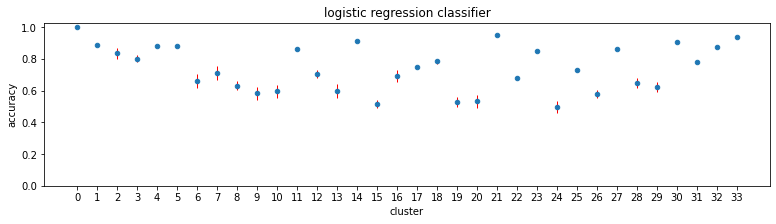

In [102]:
df_logr = pd.DataFrame.from_dict(dict_logr)

numb_clusters = df_logr.shape[1]
clusters_list = np.arange(numb_clusters)
mean_list_logr = []
std_list_logr = []

for i in np.arange(numb_clusters):
    mean_list_logr.append(np.mean(df_logr[i]))
    std_list_logr.append(np.std(df_logr[i]))

clusters_array = np.array(clusters_list)
mean_logr_array = np.array(mean_list_logr)
std_logr_array = np.array(std_list_logr)

plt.figure(figsize=(13,3))
plt.errorbar(clusters_array, mean_logr_array, std_logr_array, linestyle='None', marker='o', markersize=4.5, lw=1, ecolor='red')
plt.xlabel('cluster')
plt.ylabel('accuracy')
plt.title('logistic regression classifier')
plt.xticks(clusters_array)
plt.yticks(np.arange(0, 1.2, step=0.2))

plt.show()

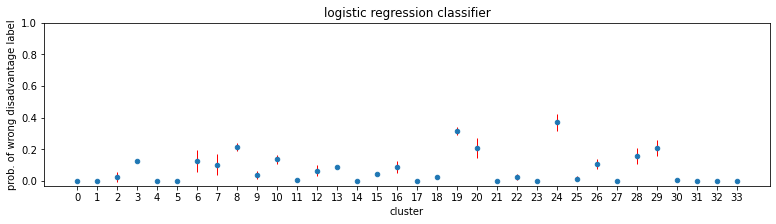

In [101]:
df_wrong_logr = pd.DataFrame.from_dict(wrong_logr)

mean_list_wrong_logr = []
std_list_wrong_logr = []

for i in np.arange(numb_clusters):
    mean_list_wrong_logr.append(np.mean(df_wrong_logr[i]))
    std_list_wrong_logr.append(np.std(df_wrong_logr[i]))

mean_wrong_logr_array = np.array(mean_list_wrong_logr)
std_wrong_logr_array = np.array(std_list_wrong_logr)

plt.figure(figsize=(13,3))
plt.errorbar(clusters_array, mean_wrong_logr_array, std_wrong_logr_array, linestyle='None', marker='o', markersize=4.5, lw=1, ecolor='red')
plt.xlabel('cluster')
plt.ylabel('prob. of wrong disadvantage label')
plt.title('logistic regression classifier')
plt.xticks(clusters_array)
plt.yticks(np.arange(0, 1.2, step=0.2))
plt.show()

### 2. XGboost classifier 

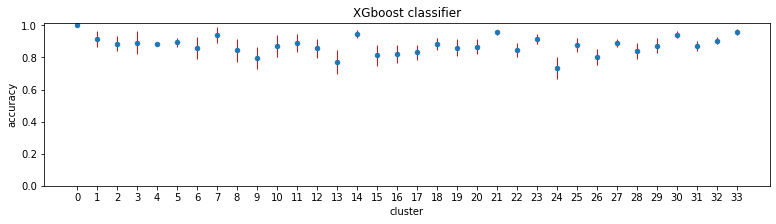

In [110]:
df_xg = pd.DataFrame.from_dict(dict_xg)

mean_list_xg = []
std_list_xg = []

for i in np.arange(numb_clusters):
    mean_list_xg.append(np.mean(df_xg[i]))
    std_list_xg.append(np.std(df_xg[i]))

mean_xg_array = np.array(mean_list_xg)
std_xg_array = np.array(std_list_xg)

plt.figure(figsize=(13,3))
plt.errorbar(clusters_array, mean_xg_array, std_xg_array, linestyle='None', marker='o', markersize=4.5, lw=1, ecolor='red')
plt.xlabel('cluster')
plt.ylabel('accuracy')
plt.title('XGboost classifier')
plt.xticks(clusters_array)
plt.yticks(np.arange(0, 1.2, step=0.2))
plt.show()

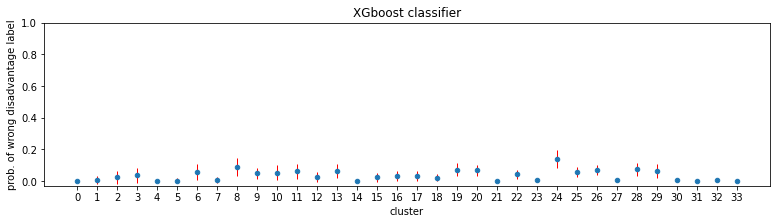

In [111]:
df_wrong_xg = pd.DataFrame.from_dict(wrong_xg)

mean_list_wrong_xg = []
std_list_wrong_xg = []

for i in np.arange(numb_clusters):
    mean_list_wrong_xg.append(np.mean(df_wrong_xg[i]))
    std_list_wrong_xg.append(np.std(df_wrong_xg[i]))

mean_wrong_xg_array = np.array(mean_list_wrong_xg)
std_wrong_xg_array = np.array(std_list_wrong_xg)

plt.figure(figsize=(13,3))
plt.errorbar(clusters_array, mean_wrong_xg_array, std_wrong_xg_array, linestyle='None', marker='o', markersize=4.5, lw=1, ecolor='red')
plt.xlabel('cluster')
plt.ylabel('prob. of wrong disadvantage label')
plt.title('XGboost classifier')
plt.xticks(clusters_array)
plt.yticks(np.arange(0, 1.2, step=0.2))
plt.show()

### 3. Support Vector Machine classifier 

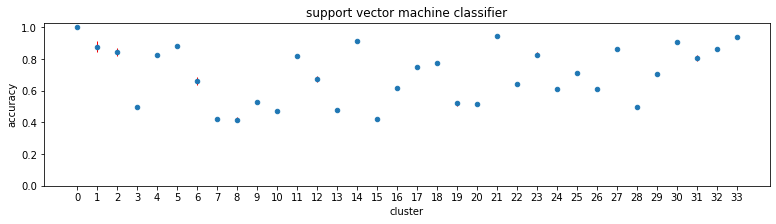

In [108]:
df_svm = pd.DataFrame.from_dict(dict_svm)

mean_list_svm = []
std_list_svm = []

for i in np.arange(numb_clusters):
    mean_list_svm.append(np.mean(df_svm[i]))
    std_list_svm.append(np.std(df_svm[i]))

mean_svm_array = np.array(mean_list_svm)
std_svm_array = np.array(std_list_svm)

plt.figure(figsize=(13,3))
plt.errorbar(clusters_array, mean_svm_array, std_svm_array, linestyle='None', marker='o', markersize=4.5, lw=1, ecolor='red')
plt.xlabel('cluster')
plt.ylabel('accuracy')
plt.title('support vector machine classifier')
plt.xticks(clusters_array)
plt.yticks(np.arange(0, 1.2, step=0.2))
plt.show()

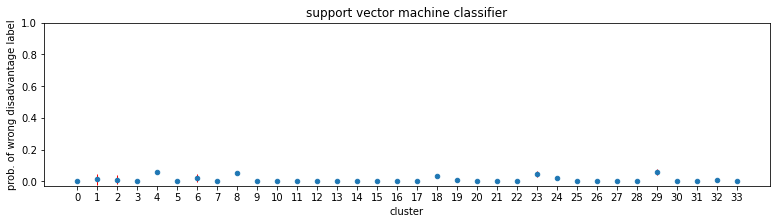

In [109]:
df_wrong_svm = pd.DataFrame.from_dict(wrong_svm)

mean_list_wrong_svm = []
std_list_wrong_svm = []

for i in np.arange(numb_clusters):
    mean_list_wrong_svm.append(np.mean(df_wrong_svm[i]))
    std_list_wrong_svm.append(np.std(df_wrong_svm[i]))

mean_wrong_svm_array = np.array(mean_list_wrong_svm)
std_wrong_svm_array = np.array(std_list_wrong_svm)

plt.figure(figsize=(13,3))
plt.errorbar(clusters_array, mean_wrong_svm_array, std_wrong_svm_array, linestyle='None', marker='o', markersize=4.5, lw=1, ecolor='red')
plt.xlabel('cluster')
plt.ylabel('prob. of wrong disadvantage label')
plt.title('support vector machine classifier')
plt.xticks(clusters_array)
plt.yticks(np.arange(0, 1.2, step=0.2))
plt.show()